## AIMI High School Internship 2023
### Notebook 2: Training a Vision Model to Predict ET Distances

**The Problem**: Given a chest X-ray, our goal in this project is to predict the distance from an endotracheal tube to the carina. This is an important clinical task - endotracheal tubes that are positioned too far (>5cm) above the carina will not work effectively.

**Your Second Task**: You should now have a training dataset consisting of (a) chest X-rays and (b) annotations indicating the distance of the endotracheal tube from the carina. Now, your goal is to train a computer vision model to predict endotracheal tube distance from the image. You have **two options** for this task, and you may attempt one or both of these:
- *Distance Categorization* : Train a model to determine whether the position of a tube is abnormal (>5.0 cm) or normal (≤ 5.0 cm).
- *Distance Prediction*: Train a model that predicts the distance of the endotracheal tube from the carina in centimeters.

In this notebook, we provide some simple starter code to get you started on training a computer vision model. You are not required to use this template - feel free to modify as you see fit.

**Submitting Your Model**: We have created a leaderboard where you can submit your model and view results on the held-out test set. We provide instructions below for submitting your model to the leaderboard. **Please follow these directions carefully**.

We will evaluate your results on the held-out test set with the following evaluation metrics:
- *Distance Categorization* : We will measure AUROC, which is a metric commonly used in healthcare tasks. See this blog for a good explanation of AUROC: https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/
- *Distance Prediction*: We will measure the mean average error (also known as L1 distance) between the predicted distances and the true distances.


## Load Data
Before you begin, make sure to go to `Runtime` > `Change Runtime Type` and select a T4 GPU. Then, upload `data.zip`. It should take about 10 minutes for these files to be uploaded. Then, run the following cells to unzip the dataset (which should take < 10 seconds)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://storage.googleapis.com/misc_jb/drive-download-20230620T044532Z-001.zip

--2023-06-29 16:02:41--  https://storage.googleapis.com/misc_jb/drive-download-20230620T044532Z-001.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320879178 (306M) [application/zip]
Saving to: ‘drive-download-20230620T044532Z-001.zip’

drive-download-2023 100%[===================>] 306.01M  75.7MB/s    in 4.2s    

2023-06-29 16:02:46 (73.1 MB/s) - ‘drive-download-20230620T044532Z-001.zip’ saved [320879178/320879178]



In [ ]:
!unzip drive-download-20230620T044532Z-001.zip

Archive:  drive-download-20230620T044532Z-001.zip
  inflating: mimic_test_student.csv  
  inflating: mimic_train_student.csv  
  inflating: mimic-test.zip          
  inflating: mimic-train.zip         


In [ ]:
!unzip -qq /content/mimic-train.zip

In [ ]:
!unzip -qq /content/mimic-test.zip

In [ ]:
data = pd.read_csv("mimic_train_labels.csv")
data['Labels'] = data['measures']<=5
data

,Unnamed: 0.1,Unnamed: 0,patient_id,image_path,report_path,measures,positioning,Labels
0,0,0,13282,mimic-train/13282/56112/91263.jpg,mimic-train/13282/56112.txt,6.0,0,False
1,2,2,13360,mimic-train/13360/54397/84764.jpg,mimic-train/13360/54397.txt,5.6,0,False
2,3,3,13360,mimic-train/13360/57560/92873.jpg,mimic-train/13360/57560.txt,4.6,1,True
3,4,4,13360,mimic-train/13360/62326/88457.jpg,mimic-train/13360/62326.txt,5.0,1,True
4,5,5,13360,mimic-train/13360/59248/87908.jpg,mimic-train/13360/59248.txt,1.8,1,True
...,...,...,...,...,...,...,...,...
11560,12240,12240,13795,mimic-train/13795/60202/87633.jpg,mimic-train/13795/60202.txt,3.7,1,True
11561,12241,12241,13795,mimic-train/13795/60202/82617.jpg,mimic-train/13795/60202.txt,3.7,1,True
11562,12242,12242,13818,mimic-train/13818/59053/93743.jpg,mimic-train/13818/59053.txt,4.7,1,True
11563,12243,12243,13906,mimic-train/13906/62812/85124.jpg,mimic-train/13906/62812.txt,3.5,1,True


## Import Libraries
We are leveraging the PyTorch framework to train our models. For more information and tutorials on PyTorch, see this link: https://pytorch.org/tutorials/beginner/basics/intro.html

In [ ]:
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from torch.utils.data import Dataset
from PIL import Image

import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torch.nn as nn
from torchvision import datasets, transforms, models

import torch.nn as nn
import numpy as np

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

## Create Dataloaders
We will implement a custom Dataset class to load in data. A custom Dataset class must have three methods: `__init__`, which sets up any class variables, `__len__`, which defines the total number of images, and `__getitem__`, which returns a single image and its paired label.

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

device = "cuda:0" if torch.cuda.is_available() else "cpu"

class ChestXRayDataset(Dataset):
    def __init__(self, img_paths, labels, distances):
        super(ChestXRayDataset, self).__init__()
        self.img_paths = img_paths
        self.labels = labels
        self.distances = distances

    def __len__(self):

        return self.labels.shape[0]

    def __getitem__(self, idx):
        out_dict = {"idx": torch.tensor(idx),}

        im = Image.open(f"/content/{self.img_paths[idx]}")

        w, h = im.size
        ima = Image.new('RGB', (w,h))
        data = zip(im.getdata(), im.getdata(), im.getdata())
        ima.putdata(list(data))
        convert_tensor = transforms.Compose([
            transforms.Resize(size=224),
            transforms.ToTensor(),
        ])

        img_as_tensor = convert_tensor(ima)
        img_as_tensor.requires_grad_ = True
        out_dict["img"] = img_as_tensor
        out_dict["labels"] = self.labels[idx]
        out_dict["distance"] = self.distances[idx]

        return out_dict

print(device)

cuda:0


## Define Training Components
Here, define any necessary components that you need to train your model, such as the model architecture, the loss function, and the optimizer.

In [ ]:
img_paths = data["image_path"].to_numpy()
labels = data["positioning"].to_numpy()
distances = data["measures"].to_numpy()

dataset = ChestXRayDataset(img_paths=img_paths, labels=labels, distances=distances)

def get_train_val_split(dataset, batch_size=10, train_prop=0.8):
    dataset_length = len(dataset)
    train_length = int(dataset_length * train_prop)
    val_length = dataset_length - train_length
    train_dataset, val_dataset = random_split(
            dataset, [train_length, val_length]
        )

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader, val_loader

train_loader, val_loader = get_train_val_split(dataset, batch_size=32, train_prop=0.9)

print(len(train_loader.dataset))
print(len(val_loader.dataset))


10408
1157


## Training Code
We provide starter code below that implements a simple training loop in PyTorch. Feel free to modify as you see fit.

In [ ]:
def calculate_scores(y_true, y_pred):
   y_pred = y_pred.flatten()
   locs_positive = np.where(y_pred > 0.5)
   y_pred = np.zeros(y_pred.shape[0])
   y_pred[locs_positive] = 1
   return f1_score(y_true, y_pred), accuracy_score(y_true, y_pred)

def validate(model, loss_fn, val_loader):

    f1_scores, acc_scores = [], []
    total_loss = 0
    for data in tqdm(val_loader):
        model.eval()
        with torch.no_grad():
            inputs = data["img"].type(torch.FloatTensor).to(device)
            labels = data["labels"].type(torch.FloatTensor).to(device)
            outputs = model(inputs)
            loss_val = loss_fn(torch.flatten(outputs), labels)
            total_loss += loss_val.item()

        f1, acc = calculate_scores(labels.detach().cpu().numpy(), torch.sigmoid(outputs).detach().cpu().numpy())
        f1_scores.append(f1)
        acc_scores.append(acc)
    return np.mean(f1_scores), np.mean(acc_scores), total_loss

def train(model, loss_fn, train_loader, opt):
    f1_scores, rocauc_scores, acc_scores = [], [], []
    total_loss = 0
    for data in tqdm(train_loader):
        model.train()
        inputs = data["img"].type(torch.FloatTensor).to(device)
        labels = data["labels"].type(torch.FloatTensor).to(device)
        opt.zero_grad()
        outputs = model(inputs)
        loss_val = loss_fn(torch.flatten(outputs), labels)
        total_loss += loss_val.item()
        loss_val.backward()
        opt.step()

        f1, acc = calculate_scores(labels.detach().cpu().numpy(), torch.sigmoid(outputs).detach().cpu().numpy())
        f1_scores.append(f1)
        acc_scores.append(acc)
    return np.mean(f1_scores), np.mean(acc_scores), total_loss

def batch_progress(epoch, tr_f1, tr_acc, tr_loss, val_f1, val_acc, val_loss):
    # Batch train data
    print(f"Epoch {epoch} Training Statistics")
    print(f"F1 Score: {tr_f1}\n Accuracy: {tr_acc}\n Loss: {tr_loss}\n")
    # Batch validation data
    print(f"Epoch {epoch} Validation Statistics")
    print(f"F1 Score: {val_f1}\n Accuracy: {val_acc}\n Loss: {val_loss}\n")



In [ ]:
def get_model(num_classes):
    resnet50_mod = models.resnet50(weights="ResNet50_Weights.DEFAULT")
    n_features = resnet50_mod.fc.in_features
    try:
        resnet50_mod.fc = nn.Sequential(
            nn.Linear(n_features, n_features),
            nn.ReLU(),
            nn.Linear(n_features, num_classes),
        )
        for i, child in enumerate(resnet50_mod.children()):
          if i == 9:
            for param in child.parameters():
                param.requires_grad = True
            break
          for param in child.parameters():
                param.requires_grad = False
    except Exception as e:
        print("ERROR: model.fc = nn.Linear(n_features, K)")
        raise e
    return resnet50_mod

import os

def save_model(model, epoch, optimizer, val_f1, val_acc, val_loss,
               tr_f1, tr_acc, tr_loss, file_name):
    print("Saving model checkpoint at epoch", epoch)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_f1': val_f1,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'train_f1': tr_f1,
        'train_acc': tr_acc,
        'train_loss': tr_loss,
    }

    # Create a folder to store the checkpoint file
    folder_path = 'model_checkpoints'
    os.makedirs(folder_path, exist_ok=True)

    # Save the checkpoint file
    file_path = os.path.join(folder_path, f"{file_name}.pth")
    torch.save(checkpoint, file_path)
    print(f"Model checkpoint saved to: {file_path}")

model = get_model(num_classes=1).to(device)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch.nn as nn
import numpy as np

opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_fn = nn.BCEWithLogitsLoss()
CHECKPOINTS = [5]

EXPERIMENT_NAME = "resnet50_tl_exp_5"
NUM_EPOCHS = 5

train_f1, train_acc, train_loss = [], [], []
val_f1, val_acc, val_loss = [], [], []
best_model_metrics = {"best_val_acc": 0.0,
                      "best_val_f1": 0.0,
                      "best_val_loss":0.0}
for epoch in range(NUM_EPOCHS):
    batch_tr_f1, batch_tr_acc, batch_tr_loss = train(model, loss_fn, train_loader, opt)
    batch_val_f1, batch_val_acc, batch_val_loss = validate(model, loss_fn, val_loader)

    batch_progress(
        epoch, batch_tr_f1, batch_tr_acc, batch_tr_loss,
        batch_val_f1, batch_val_acc, batch_val_loss
        )

    train_f1.append(batch_tr_f1)
    train_acc.append(batch_tr_acc)
    train_loss.append(batch_tr_loss)

    val_f1.append(batch_val_f1)
    val_acc.append(batch_val_acc)
    train_loss.append(batch_val_loss)

    if best_model_metrics["best_val_acc"] < batch_val_acc :
      best_model_metrics["best_val_acc"] = batch_val_acc
      best_model_metrics["best_val_f1"] = batch_val_f1
      best_model_metrics["best_val_loss"] = batch_val_loss
      save_model(
           model, epoch, opt, val_f1, val_acc, val_loss,
           train_f1, train_acc, train_loss,
           f"{EXPERIMENT_NAME}_epoch_{epoch}"
          )
    print(f'Your best model has \n \
        Val Acc: {best_model_metrics["best_val_acc"]} \n \
        Val F1: {best_model_metrics["best_val_f1"]}')

## TRAINING COMPLETE ##
save_model(
           model, epoch, opt, val_f1, val_acc, val_loss,
           train_f1, train_acc, train_loss,
           f"{EXPERIMENT_NAME}_epoch_{NUM_EPOCHS}"
          )

train_f1 = np.array(train_f1)
train_acc = np.array(train_acc)
train_loss = np.array(train_loss)

val_f1 = np.array(val_f1)
val_acc = np.array(val_acc)
val_loss = np.array(val_loss)

100%|██████████| 36/36 [01:16<00:00,  2.14s/it]


Epoch 0 Training Statistics
F1 Score: 0.8248170594060144
 Accuracy: 0.7086538461538462
 Loss: 190.59993797540665

Epoch 0 Validation Statistics
F1 Score: 0.8260527280607369
 Accuracy: 0.7100694444444444
 Loss: 20.546646028757095

Saving model checkpoint at epoch 0
Model checkpoint saved to: model_checkpoints/resnet50_tl_exp_5_epoch_0.pth
Your best model has 
         Val Acc: 0.7100694444444444 
         Val F1: 0.8260527280607369


100%|██████████| 36/36 [01:16<00:00,  2.13s/it]


Epoch 1 Training Statistics
F1 Score: 0.8220211613556603
 Accuracy: 0.715
 Loss: 183.30790930986404

Epoch 1 Validation Statistics
F1 Score: 0.824892184447087
 Accuracy: 0.7196180555555556
 Loss: 20.47095113992691

Saving model checkpoint at epoch 1
Model checkpoint saved to: model_checkpoints/resnet50_tl_exp_5_epoch_1.pth
Your best model has 
         Val Acc: 0.7196180555555556 
         Val F1: 0.824892184447087


100%|██████████| 36/36 [01:15<00:00,  2.10s/it]


Epoch 2 Training Statistics
F1 Score: 0.826512077012758
 Accuracy: 0.7254807692307692
 Loss: 177.54432013630867

Epoch 2 Validation Statistics
F1 Score: 0.8249044395544342
 Accuracy: 0.7135416666666666
 Loss: 20.901028096675873

Your best model has 
         Val Acc: 0.7196180555555556 
         Val F1: 0.824892184447087


100%|██████████| 36/36 [01:18<00:00,  2.17s/it]


Epoch 3 Training Statistics
F1 Score: 0.8259661389071079
 Accuracy: 0.7283653846153846
 Loss: 175.0719091296196

Epoch 3 Validation Statistics
F1 Score: 0.821193584504216
 Accuracy: 0.7196180555555556
 Loss: 20.840418368577957

Your best model has 
         Val Acc: 0.7196180555555556 
         Val F1: 0.824892184447087


100%|██████████| 36/36 [01:19<00:00,  2.21s/it]


Epoch 4 Training Statistics
F1 Score: 0.8343012989360764
 Accuracy: 0.7452884615384615
 Loss: 170.14203026890755

Epoch 4 Validation Statistics
F1 Score: 0.7904534781172613
 Accuracy: 0.6979166666666666
 Loss: 21.196927070617676

Your best model has 
         Val Acc: 0.7196180555555556 
         Val F1: 0.824892184447087
Saving model checkpoint at epoch 4
Model checkpoint saved to: model_checkpoints/resnet50_tl_exp_5_epoch_5.pth


In [ ]:
import time

# Run an infinite loop
while True:
    print("Colab is running...")
    time.sleep(1200)


Colab is running...
Colab is running...
Colab is running...
Colab is running...
Colab is running...
Colab is running...
Colab is running...


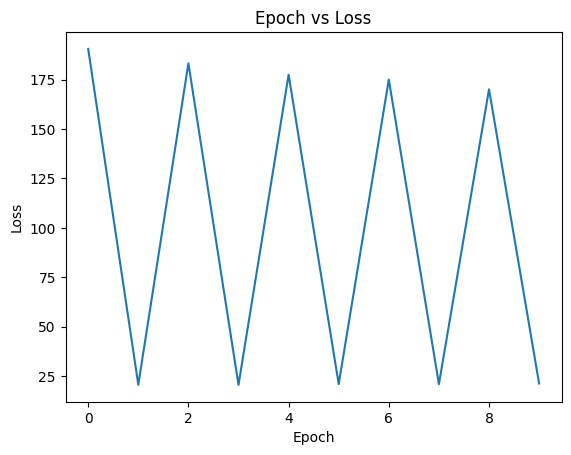

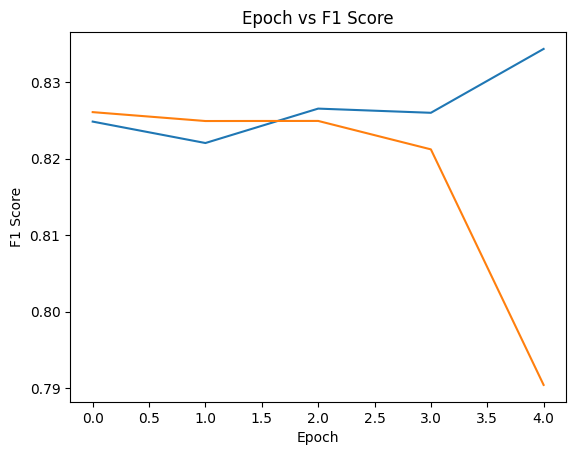

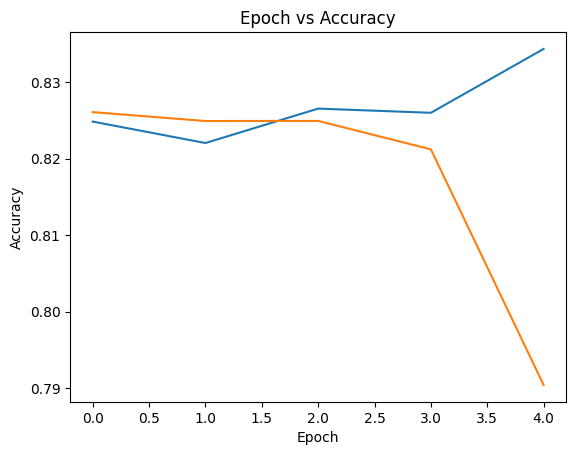

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Epoch vs Loss')
plt.show()

# Plot f1
plt.plot(train_f1, label="Train F1")
plt.plot(val_f1, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title('Epoch vs F1 Score')
plt.show()

# Plot Accuracy
plt.plot(train_f1, label="Train Acc")
plt.plot(val_f1, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Epoch vs Accuracy')
plt.show()


## Submitting Your Results
Once you have successfully trained your model, generate predictions on the test set and save your results as a `.csv` file. This file can then be uploaded to the leaderboard.

Your final `.csv` file **must** have the following format:
- There must be a column titled `image_path` with the paths to the test set images. This column should be identical to the one provided in `mimic_test_student.csv`.
- There must be a column titled `pred` with your model outputs.
  - If you are running the `distance categorization` task, this column must have floating point numbers ranging between 0 and 1. Higher numbers should indicate a greater likelihood that the tube distance is abnormal. Hint: You can convert model outputs to the 0 to 1 range by applying the sigmoid activation function (torch.nn.sigmoid())
  - If you are running the `distance prediction` task, this column must have numbers representing the tube distance in centimeters.
- Double check that there are 500 rows in your output file

In [ ]:
model = # Model Architecture
ckpt = torch.load("/content/best.pkl")
model.load_state_dict(ckpt["state_dict"])

test_dataset = ChestXRayDataset("""Fill in args here""")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, drop_last=False)

test_results = {"image_path": [], "pred": []}
# Write method to load in data from test_loader, compute model predictions, and append results to test_results dict


In [ ]:
test_results = pd.DataFrame(test_results)
test_results.to_csv(f"/content/test.csv")